## Classifying the Palmer Penguins

![Image source: \@allisonhorst](https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png)

Our data set for these notes is Palmer Penguins. This data set contains physiological measurements and species labels for several populations of Adelie, Chinstrap, and Gentoo penguins. 

## Abstract 

In this blog post we use a logistic regression model in order to classify Palmer penguins according to their `Species`. We find that using information such as the `Island` of the penguin as well as `Culmen Depth (mm)` and `Culmen Length` are sufficient features in order to provide an accurate classifying model. Within this blog post, we examine multiple data visualizations and tables in order to better understand the data and develop our reasoning for choosing the features of the model.

Below we will import the dataset we will use for this Blog Post

In [2]:
import pandas as pd
import numpy as np
train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

## Data Preparation

In order to prepare the qualitative columns in the data, we must convert categorical feature columns like `Sex` and `Island` into 0-1 columns using `pd.get_dummies` function. 

The label column `Species` will also needed to be coded differently, using a `LabelEncoder`

The following function will take care of these processes:

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

# Replace the column with the first word in each entry 
train["Species"] = train["Species"].str.split().str.get(0)

## Visualizations of the Data

For the dataset, I created two plots and one summary table in order to contextualize the data. 

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns


<Axes: xlabel='Island', ylabel='Species'>

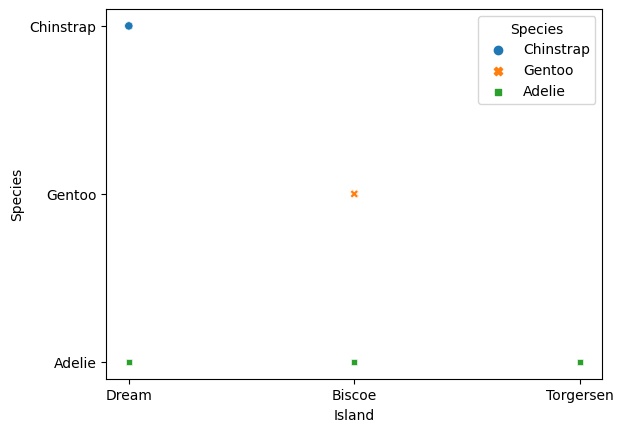

In [11]:
#| label: fig-scatter-island
#| fig-cap: Island Distribution for Each Penguin Species

sns.scatterplot(train, x = "Island", y = "Species", hue = "Species", style = "Species")

After running through a multitude of different plots with varying sets of data, one combination that particularly stood out to me is shown in @fig-scatter-island. The plot shows the distribution of each species of Penguin on the three islands within the dataset. Now while it seems rather plain and simple at first glance, take note that for one of these islands (Torgersen), only one species of penguins resides there, that being Adeilie. Upon further investigation, for the remaining two islands, at most, only two differing penguin species reside there. Adelie inhabit all three islands while Chinstrap penguins reside only on the Dream island and Gentoo Penguins are only found on the Biscoe Island.

The reason as to why this rather simple analysis is so interesting as it presents a way in which we no longer have to compare all three species against one another at a given point. Rather, we can now determine whether the penguin presented to us is one of two species if the island is Dream or Biscoe. In the case of Torgersen, we automatically know the penguin will be Adelie as they are the only species of Penguins that reside there!

This knowledge, paired with two more quantitative features, should allow the model to classify a penguin more accurately!

<Axes: xlabel='Culmen Depth (mm)', ylabel='Culmen Length (mm)'>

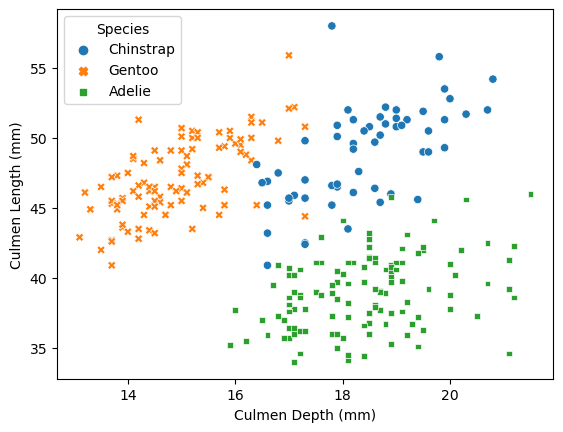

In [9]:
#| label: fig-scatterplot-culmen
#| fig-capt: Distribution of Culmen Depth vs Length for Each Penguin Species

sns.scatterplot(train, x = "Culmen Depth (mm)", y = "Culmen Length (mm)", hue = "Species", style = "Species")

With that idea now set. Let's move on to the second visualization, shown by @fig-scatterplot-culmen. This is a more traditional scatterplot showing the distributions of `Culmen_Depth` and `Culmen_Length` for all three species of penguin.

Now recalling @fig-scatter-island, the main relationships we want to focus on are **Chinstrap vs Adelie** and **Gentoo vs Adelie** as these are the only relationships where penguins coexist on the same island. 

As we can see from the @fig-scatterplot-culmen. Gentoo penguins seem to exhbit a longer culmen length but shorter culmen depth. <br>
 Adelie penguins have a shorter culmen length compared to Gentoo penguins but a higher culmen depth. <br> Chinstrap penguins appear to have the longest average combination of culmen depth/length out of all the penguins.

Referring back to those relationships as mentioned previously, Gentoo and Adelie penguins seem to have a clear divide amongst one another in terms of culmen length/depth. Chinstrap and Adelie penguins seem to overlap at some points in the graph but fairly slightly.

All things considered, given the properties of both @fig-scatter-island and @fig-scatterplot-culmen, the combination of these three features will be useful as a starting reference for my model.

In [6]:
## Summary table for the mean body mass of each species of penguin by sex

summary_table = train.groupby(['Species', 'Sex']).agg({'Body Mass (g)': 'mean'})

print(summary_table)

                  Body Mass (g)
Species   Sex                  
Adelie    FEMALE    3350.471698
          MALE      4052.868852
Chinstrap FEMALE    3523.387097
          MALE      4005.769231
Gentoo    .         4875.000000
          FEMALE    4684.693878
          MALE      5476.704545


My last visualization was a simple summary table of the mean body mass (g) of each penguin species by sex. I wanted to ensure that I was covering a large portion of the data, so by doing so, I can cover two features of the dataset I did not cover in the two previous data plots.

**As a quick analysis:** <br>
Gentoo Males exhibit the largest mean body mass (g) out of all the male species <br>
Similarly Gentoo females also exhibit the largest mean body mass (g) out of all the female species <br>
In regards to Adelie and Chinstrap penguins, both males and females exhibit a similar mean mass (g) in relation to the other species. 

With that in mind, the combination of body mass (g) and sex do not seem like a good pairing to use for predicition due to the similar nature of both Adelie and Chinstrap penguins.

## Model Choices

For this blog, I used the `combinations` function from the `itertools` package in order to go through each variation of both qualitative and quantitative features.

In [7]:
from itertools import combinations

all_qual_cols = ["Clutch Completion", "Sex", "Island", "Region", ]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)']

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 

I then utilized the `LoigisticRegression` model from `sklearn` in order to run tests for each iteration.

In [8]:
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions # for visualization later

cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']

LR = LogisticRegression(max_iter=10000)
LR.fit(X_train[cols], y_train)
LR.score(X_train[cols], y_train)

0.99609375

Going through each iteration, I scored each of them found below:

['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Length (mm)', 'Culmen Depth (mm)']: .96 <br>
['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Length (mm)', 'Flipper Length (mm)']: .95 <br>
['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Length (mm)', 'Body Mass (g)'] : .91 <br>
['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Depth (mm)', 'Flipper Length (mm)']: .91 <br>
['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Depth (mm)', 'Body Mass (g)'] : .76 <br>
['Clutch Completion_No', 'Clutch Completion_Yes', 'Flipper Length (mm)', 'Body Mass (g)'] : .63 <br>
['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Culmen Depth (mm)'] : .992 <br>
['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Flipper Length (mm)'] : .98 <br>
['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Body Mass (g)'] : .98 <br>
['Sex_FEMALE', 'Sex_MALE', 'Culmen Depth (mm)', 'Flipper Length (mm)'] : .82 <br>
['Sex_FEMALE', 'Sex_MALE', 'Culmen Depth (mm)', 'Body Mass (g)'] : .77 <br>
['Sex_FEMALE', 'Sex_MALE', 'Flipper Length (mm)', 'Body Mass (g)'] : .71 <br>
['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)'] : .996 <br>
['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Flipper Length (mm)']: .97 <br>
['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Body Mass (g)']: .97 <br>
['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Depth (mm)', 'Flipper Length (mm)']:.88 <br>
['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Depth (mm)', 'Body Mass (g)']: .83 <br>
['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Flipper Length (mm)', 'Body Mass (g)'] : .75 <br>

# The most successful being: 
['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)'] : .996 <br>

# Cross Evaluation

I did not want to limit myself to only one model however, so I used `cross_val_score` from the `sklearn.model_selection` in order to compare how the Logisitic Regression model held up against that of a `Support Vector Classifier`

I first imported `SVC` from the `sklearn` package and ran each iteration as before through the model. 

An example of this is found below

In [89]:
from sklearn.svm import SVC # support vector classifier
SVM = SVC(gamma = 5)
SVM.fit(X_train[cols], y_train)


SVC(gamma=5)

Using cross-validation is important in order to combat overfitting. It is utilized in order to see how the models predict based on information they have never seen before by withholding certain aspects of the training data. 

In [67]:
from sklearn.model_selection import cross_val_score

cv_scores_LR = cross_val_score(LR, X_train[cols], y_train, cv=5)
cv_scores_LR.mean()


0.9883107088989442

In [68]:
cv_scores_SVM = cross_val_score(SVM, X_train[cols], y_train, cv=5)
cv_scores_SVM.mean()

0.8592760180995475

In every iteration, the Logistic Regression Model **outclassed** the Support Vector Classifier model. 

## Testing 

In order to test the model, I am downloading the dataset and preparing it via the `prepare_data` function

In [94]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)
LR.score(X_test[cols], y_test)

1.0

**Awesome!** Our model is able to classify the three species of penguins with **100 percent accuracy**.


![Happy Penguins](happy_penguin.jpg){#fig-penguin}

## PLotting Decision Regions

I will be using the `plot_regions` function below in order to plot my decision regions for my model.

In [97]:
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Gentoo", "Chinstrap", "Adelie"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

For the purposes of this blog post, we will look at the decision regions for both our `training data` and our `testing data`

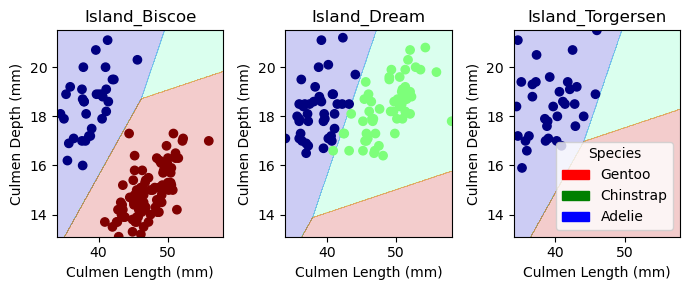

In [98]:
#| label: fig-decision-region-training
#| fig-cap: Decision Regions for each island based on training data

plot_regions(LR, X_train[cols], y_train)

The three plots above correspond to the decision regions for each island. As previously mentioned in the data visualization section, we see that for the Biscoe and Dream islands, there are only two species of penguins. For the Torgersen island, only the Adelie penguins reside there. As predicted, this results in comparing at most only two species of penguins against one another, allowing for easier classification.

The following section displays the decision regions our model makes for the testing data. 

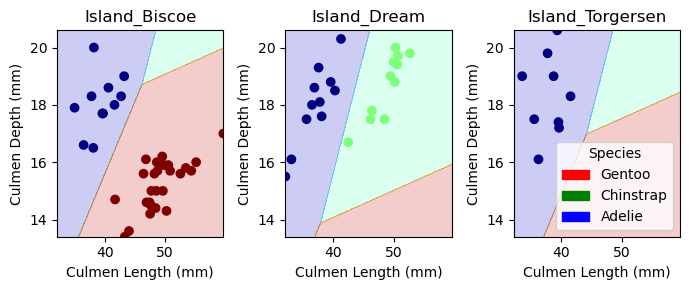

In [99]:
#| label: fig-decision-region-testing
#| fig-cap: Decision Regions for each island based on testing data

plot_regions(LR, X_test[cols], y_test)

Our testing data yielded a smaller number of penguins to be classified, but our classifier was able to accurately predict each species of penguin based on our three features of `Island`, `Culmen Depth (mm)`, and `Culmen Length (mm)`

While the penguins on the Torgersen would always be Adelie, and were classified as such. The closest decision region our model came to for classification of the test data was a penguin on the Dream Island. This was anticipated however as in @fig-scatterplot-culmen, Adelie and Chinstrap penguins share some overlapping points in regards to `Culmen Depth (mm)` and `Culmen Length(mm)`


## Confusion Matrix

I will be using a confusion matrix for my model, evaluated on the test set.

In order to do this I will be using `confusion_matrix` from the `sklearn` package.

In [108]:
from sklearn.metrics import confusion_matrix

y_test_pred = LR.predict(X_test[cols])
C = confusion_matrix(y_test, y_test_pred)
C

array([[31,  0,  0],
       [ 0, 11,  0],
       [ 0,  0, 26]])

In this confusion matrix, due to our **100 percent prediction accuracy**, we do not see any errors within our matrix. As a reference, the confusion matrix just gives the number of data points that have the correct label. 

Logically, since our model predicts each penguin correctly, there will be disparities in the matrix. 

That being said, as previously mentioned, the most likely error to occur within our model is classifying a penguin from the Dream island. This is due to the Adelie and Chinstrap penguins sharing the most similar distributions of `Culmen Depth (mm)` and `Culmen Length (mm)` which depending on the penguin's dimensions, has the highest likelihood out of all the species to overlap in the incorrect species decision region.

## Discussion

In this blog post, I have found that the using `Island`, `Culmen Depth (mm)`, and `Culmen Length (mm)` features in a logistic regression model are useful for accurately classifying species of penguins pertaining to Adelie, Gentoo, and Chinstrap as seen in @fig-decision-region-testing

I have found that Adelie penguins reside in all three islands (Dream, Biscoe, Torgersen), while Gentoo penguins only reside on the Biscoe island and Chinstrap penguins only inhabit the Biscoe island. 

In terms of `Culmen Length (mm)` and `Culmen Depth (mm)` we found that:

 Gentoo penguins seem to exhbit a longer culmen length but shorter culmen depth. <br>
 Adelie penguins have a shorter culmen length compared to Gentoo penguins but a higher culmen depth. <br> Chinstrap penguins appear to have the longest average combination of culmen depth/length out of all the penguins.

In terms of `Body Mass (g)` we found that:

Gentoo penguins, both male and female, have the highest mean body mass out of all species of penguins. 

Adelie and Chinstrap penguins exhibit similar mean body mass to one another for both male and female.

# Skills learned 

There are several skills I learned while creating this blog post. 

First and foremost, I learned how to navigate the github system/Jupiter Notebook and create this blog post in the first place.

I was able to become more familiar with data visualization tools such as `seaborn`, `matplot`, and `mlxtend` and data analysis tools as `pandas`, `sklearn` and `numpy` 

Through these tools, I was able to become more comfortable navigating the basics of machine learning and displaying information.

That being said, this is still my very first blog post and I know I have a lot to improve on/learn!